<a href="https://colab.research.google.com/github/subramario/Climate_Fever_NLP/blob/main/Climate_Fever_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations & Imports

In [ ]:
!pip install datasets
!pip install unidecode
!pip install nltk

# general purpose imports
import numpy as np
import math
import re
import string
import unidecode
import pickle

# gensim NLP models
from gensim import models
from gensim.models import Word2Vec
import gensim.downloader as api
from datasets import load_dataset

# NLP specific 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding, TSNE

# ignores deprecated warnings from appearing in output
import warnings
warnings.filterwarnings('ignore')

# for tables/plots in Jupyter
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import tabulate

# Representation Learning for Text Embedding

## Part 1

In the following section, we load and preprocess the **Climate_Feaver** dataset. For experimentation, we have extracted both **Claims** and **Evidences** from the corpus. We use these fields to create two sets: one with just **Claims** (we call this the small dataset), and one with **Claims and Evidences** (we call this the large dataset). We do this in order to examine whether a larger dataset has a positive impact on word embeddings.

<!-- We have only extracted the **Claims** from the dataset to build our text-corpus. This was done primarily for ease of computation. Next preprocessing is performed. -->




### Dataset Development

#### Extract Evidences and Claims from Climate Fever Dataset

In [ ]:
dataset = load_dataset("climate_fever")
claims = dataset['test']['claim']

evidences_list = []
for i in range (len(dataset['test']['evidences'])):
  if (i % 100 == 0):
    print (i," words completed")
  for j in range(len(dataset['test']['evidences'][i])):
    evidence = dataset['test']['evidences'][i][j]['evidence']
    evidences_list.append(evidence)

#### Preprocessing Function

The following function is used to preprocess text data. Preprocessing in NLP is conducted to remove unnecessary information, standardize the data to a specific format, and break the text down to its core components - these steps aid in developing better numerical representations for the NLP model to train with. The inclusion of elements such as capitalization, punctuation, numbers, and stop words can skew the results in a negative direction as these elements are typically inconsequential to the true meaning/context of a word. As such, the following preprocessing techniques have been performed:

*   Remove punctuation
*   Remove numbers 
*   Remove stop words
*   Convert characters to lowercase
*   Stemming

**Note:** we tried lemmatization instead of stemming, but the resulting models performed worse. Therefore, stemming was utilized instead:





In [ ]:
def preprocessing(dataset):

  for i in range(len(dataset)):
    
    # progress tracker
    if (i % 1000 == 0):
      print (i, " sentences completed")

    # convert text to lower-case
    dataset[i] = dataset[i].lower()

    # remove all punctuation from text
    dataset[i] = "".join([char for char in dataset[i] if char not in string.punctuation])

    # remove all numbers from text
    dataset[i] = dataset[i].translate(str.maketrans('', '', string.digits))

    # tokenization and removal of stopwords using NLTK
    text = dataset[i]
    text_tokens = word_tokenize(text)
    dataset[i] = [word for word in text_tokens if not word in stopwords.words()]

    # stemming
    porter = PorterStemmer()
    dataset[i] = [porter.stem(word) for word in dataset[i]]

    return dataset

As mentioned before, we will be testing the models using two different datasets. These datasets will be preprocessed and saved so that they can be loaded again for future use:

#### Create Large Dataset (Claims + Evidences), Preprocess, & Save 

In [ ]:
claims = dataset['test']['claim']
claims = claims + evidences_list
claims = preprocessing(claims)

with open("final_dataset.txt", "wb") as fp:
  pickle.dump(claims, fp)

#### Create Small Dataset (Claims), Preprocess, & Save 

In [ ]:
claims_small = dataset['test']['claim']
claims_small = preprocessing(claims_small)

with open("final_dataset_small.txt", "wb") as fp:
  pickle.dump(claims_small, fp)



---


**Note:** From this point on, you can just load the datasets instead of running the whole script again (generating the datasets take a very long time). The preprocessed datasets we have used for analysis are submitted for the assignment - you may simply load them into Google Colab and run the first cell under "Installations & Imports", then run every cell from this point onward to reproduce the results portrayed in the report.


---



#### Loading Preprocessed Datasets

In [ ]:
with open("final_dataset_small_stem.txt", "rb") as fp:
  final_data_small = pickle.load(fp)

with open("final_dataset_large_stem.txt", "rb") as fp:
  final_data_large = pickle.load(fp)

print("The size of the large data set is: {} samples".format(len(final_data_large)))
print("The size of the small data set is: {} samples".format(len(final_data_small)))

The size of the large data set is: 9210 samples
The size of the small data set is: 1535 samples


#### Split Data into Train & Test Sets

In the following code block we split the large and small dataset into training and testing sets. We perform an 80:20 split in order to ensure that an adequate number of words are present in the training of the embedding matrix. To generate the embedding matrix, the entire dataset (for each large and small dataset) will be used and the test sets will then be used to evaluate the word embeddings:
<!-- Note that the validation set will be used in the next question for the dimensionality reduction and feature extraction methods. -->

In [ ]:
num_instances_large = int(0.8 * len(final_data_large))
num_instances_small = int(0.8 * len(final_data_small))

train_large = final_data_large[:num_instances_large]
test_large = final_data_large[num_instances_large:]

train_small = final_data_small[:num_instances_small]
test_small = final_data_small[num_instances_small:]

print ("The size of the larger data train set is: {} samples".format(len(train_large)))
print ("The size of the larger data test set is:  {} samples".format(len(test_large)))
print ("The size of the smaller data train set is: {} samples".format(len(train_small)))
print ("The size of the smaller data test set is: {} samples".format(len(test_small)))

The size of the larger data train set is: 7368 samples
The size of the larger data test set is:  1842 samples
The size of the smaller data train set is: 1228 samples
The size of the smaller data test set is: 307 samples


### Train Word2Vec Model to Generate Embedding Matrix

We now train two Word2Vec models: one with the small dataset and the other with the large dataset, both in their entirety:

In [ ]:
# train models using entire dataset
model_large = Word2Vec(sentences=final_data_large, size=100, window=5, min_count=1, iter=50)
model_small = Word2Vec(sentences=final_data_small, size=100, window=5, min_count=1, iter=50)

print(model_large)
print(model_small)

Word2Vec(vocab=8258, size=100, alpha=0.025)
Word2Vec(vocab=4224, size=100, alpha=0.025)


We then extract the embeddings of the words from the train/test sets of both datasets for future analysis:

In [ ]:
test_set_flatten_large = sum(test_large, [])
test_set_words_large = list(set(list(model_large.wv.vocab.keys())).intersection(test_set_flatten_large))

test_set_flatten_small = sum(test_small, [])
test_set_words_small = list(set(list(model_small.wv.vocab.keys())).intersection(test_set_flatten_small))

train_set_flatten_large = sum(train_large, [])
train_set_words_large = list(set(list(model_large.wv.vocab.keys())).intersection(train_set_flatten_large))

train_set_flatten_small = sum(train_small, [])
train_set_words_small = list(set(list(model_small.wv.vocab.keys())).intersection(train_set_flatten_small))

# created training and testing sets
train_set_embed_large = model_large.wv[train_set_words_large]
test_set_embed_large = model_large.wv[test_set_words_large]

train_set_embed_small = model_small.wv[train_set_words_small]
test_set_embed_small = model_small.wv[test_set_words_small]

## Part 2

### Analyze Word2Vec Embedding Space - Cosine Similarity

In this section, we examine words which are present within the test sets of both the large and small datasets. We utilize the Cosine Similarity measure to understand the capability of both models in recognizing the similarity/dissimialrity between two words. We perform three tests to evaluate its ability to detect similar words, and three tests to evaluate its ability to detect dissimilar words:

In [ ]:
# find words present in both large and small test sets
words = list(set(test_set_words_large).intersection(test_set_words_small))
print(words)

['grew', 'lesser', 'time', 'see', 'largest', 'cold', 'arctic', 'page', 'along', 'mike', 'rather', 'spell', 'total', 'go', 'retreat', 'drier', 'june', 'meet', 'onward', 'moment', 'smaller', 'pdo', 'thermal', 'heat', 'reveal', 'local', 'extra', 'grace', 'school', '°c', 'liquid', 'deep', '°n', 'water', 'team', 'short', 'closer', 'better', 'meat', 'amount', 'cosmic', 'similar', 'global', 'upon', 'african', 'date', 'lead', 'warmth', 'glaciologist', 'belief', 'way', 'polar', 'market', 'right', 'glacier', 'indian', 'flow', 'sun', 'dna', 'broke', 'gone', 'enough', 'congress', 'oxygen', 'like', 'twice', 'much', 'particular', 'use', 'river', 'layer', 'globe', 'comment', 'mount', 'cm', 'glacial', 'state', 'small', 'panel', 'life', 'point', 'hot', 'draft', 'suggest', 'link', 'trenberth', 'represent', 'interview', 'journal', 'mean', 'latest', 'fraction', 'gdp', 'coral', 'nuclear', 'think', 'nasa', 'occur', 'paper', 'andor', 'peer', 'next', 'rock', 'four', 'function', 'record', 'peiser', 'least', 'r

In [ ]:
# NOTE: all words used for this experiment are within the test sets of both the large and small datasets!
def cosineSimilarity(word_1, word_2):
  result_large = model_large.wv.similarity(word_1, word_2)
  result_small = model_small.wv.similarity(word_1, word_2)
  print('Cosine Similarity - "{}" vs "{}": large = {}, small = {}\n'.format(word_1, word_2, result_large, result_small))

# similarity testing - models should achieve a high score
print("HIGH SIMILARITY TESTS")
print("-"*50)

cosineSimilarity('cool', 'cooler')
cosineSimilarity('planet', 'orbit')
cosineSimilarity('billion', 'india')

# dissimilarity testing - models should achieve a low score
print("LOW SIMILARITY TESTS")
print("-"*50)

cosineSimilarity('cancel', 'feet')
cosineSimilarity('cosmic', 'meat')
cosineSimilarity('hockey', 'livestock')

HIGH SIMILARITY TESTS
--------------------------------------------------
Cosine Similarity - "cool" vs "cooler": large = 0.3682108223438263, small = 0.9643504023551941

Cosine Similarity - "planet" vs "orbit": large = 0.30311572551727295, small = 0.868117094039917

Cosine Similarity - "billion" vs "india": large = 0.3653300702571869, small = 0.9490698575973511

LOW SIMILARITY TESTS
--------------------------------------------------
Cosine Similarity - "cancel" vs "feet": large = 0.07417888939380646, small = 0.7388037443161011

Cosine Similarity - "cosmic" vs "meat": large = 0.0001831738045439124, small = 0.8551775217056274

Cosine Similarity - "hockey" vs "livestock": large = 0.0326298251748085, small = 0.4930484890937805



The results are interesting. For similarity testing, the model trained on the small dataset (model_small) performs very well in detecting the relationship between two related words, whereas the model trained on the large dataset (model_large) performs quite poorly. However for dissimilarity testing, model_small performs quite poorly as it detects a strong relationship between two unrelated words, whereas model_large performs quite well as it portrays extremely low similarity scores.

A high cosine similarity between two dissimilar words can result due to a lack of data. By expanding the courpus with more documents, the model can improve its ability to detect dissimilar words. Another reason for high similarity measures between dissimilar words could be due to the nature of the documents themselves. As Word2Vec models rely on the neighborhood around each word to determine context, it could be possible that the documents within the corpus discuss these seemingly unreleated words in a specific way - this reason can be ruled out for this project however, as the nature of the corpus involves climate change articles (these are very unlikely to relate meat with cosmic, or feet with cancel).

Building on the prior points, since model_large has more data, its high performance detecting dissimilar words is expected. However, it portrays a much lower confidence measure when comparing two similar words - this could also potentially be attributed to having more data. Similar words could occur in more contexts in the smaller dataset than the larger one. This could reduce the significance/relationship of similar words for model_large.

## Part 3

### Analyzing Quality of Embeddings using Arithmetic Relationships

In this section, we analyze 5 word arithmetic relationships in order to examine the embedding space. **As Professor Mark Crowley explicitly stated during office hours that it is not mandatory to use kNN for evaluating the quality of embeddings *for this assignment* because it was not stated as part of the instructions**, we will not utilize it for our approach. Instead, we will use a helper function to visualize each word embedding as a vector of colors, and compare combinations of words using cosine similarity. Words which are common to both model_small and model_large will be used for experimentation of arithmetic relationships. The following words and operations will be used to analyze the quality of arithmetic relationships:

*   water - planet
*   ice - himalaya
*   asia + india
*   cold + hot
*  nasa + scientist

### Arithmetic Plotter Function

The following helper function accepts: two input words, an arithmetic operation (addition or subtraction) and a Word2Vec model. It outputs a color plot with 6 embedding representations: 1 for each input word, another for the resulting operation performed with the two input words, and three vectors which are the most similar to the resulting operation word:




In [ ]:
def compare_words_with_color(wds, operation, model):
    # outputs title
    display(HTML('<b>Word vectors for: %s</b>' % ', '.join(wds)))

    vs = []
    for word in wds:
      vs.append(model.wv[word])

    # creates resulting operation vector based on users' choice to add or subtract input words
    if operation == "plus":
      combo = model.wv[wds[0]] + model.wv[wds[1]]
      vs.append(combo)
      wds.append("{}+{}".format(wds[0], wds[1]))
    elif operation == "minus":
      combo = model.wv[wds[0]] - model.wv[wds[1]]
      vs.append(combo)
      wds.append("{}-{}".format(wds[0], wds[1]))

    # printer function to display top 3 similar vectors from model
    print("Top 3 Similar Words with Confidences")
    print("-"*50)
    for i in range(0,3):
      term = model.wv.similar_by_vector(combo)[i][0]
      confidence = model.wv.similar_by_vector(combo)[i][1]
      print(term, confidence)
      vs.append(model.wv[term])
      wds.append("({}) {}".format(i+1, term))
  
    # plotting word embedding visualizations
    dim = len(vs[0])
    fig = plt.figure(num=None, figsize=(12, 2), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    ax.set_facecolor('gray')
    
    for i,v in enumerate(vs):
      ax.scatter(range(dim),[i]*dim, c=vs[i], cmap='Spectral', s=16)
    
    plt.xlabel('Dimension')
    plt.yticks(range(len(wds)), wds)
    
    plt.show()
    print("\n")

### Arithmetic Relationships for Model_Small

Top 3 Similar Words with Confidences
--------------------------------------------------
trace 0.8359780311584473
impacted 0.8269824385643005
flows 0.8189449310302734


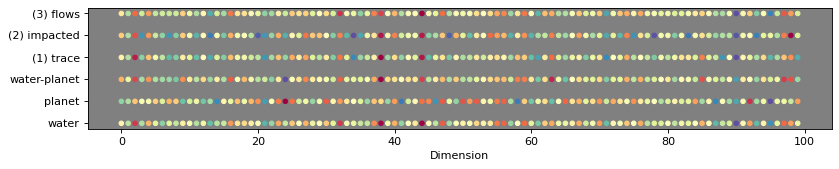

Top 3 Similar Words with Confidences
--------------------------------------------------
ice 0.9885556697845459
insulating 0.9643189311027527
greenland 0.9575119018554688


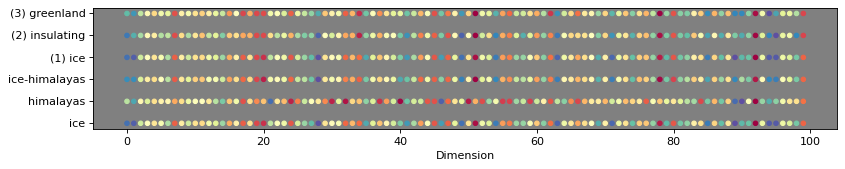

Top 3 Similar Words with Confidences
--------------------------------------------------
rainfall 0.9953187108039856
light 0.995107889175415
indonesia 0.9950090646743774


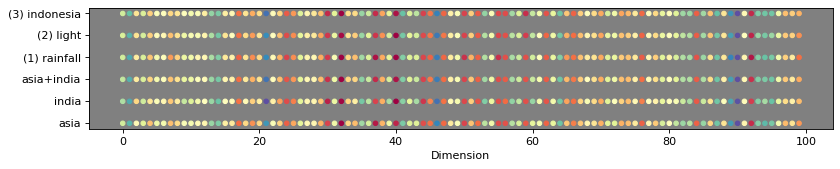

Top 3 Similar Words with Confidences
--------------------------------------------------
spring 0.9861416816711426
meanders 0.9844954013824463
europe 0.9844396114349365


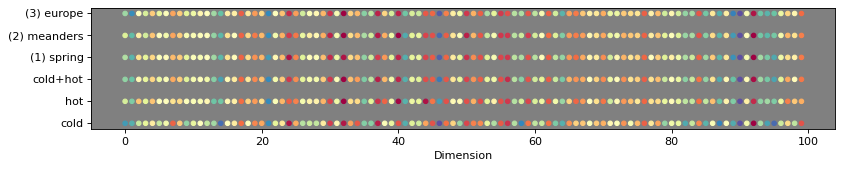

Top 3 Similar Words with Confidences
--------------------------------------------------
computed 0.9905331134796143
sensing 0.9886581897735596
washington 0.9861924648284912


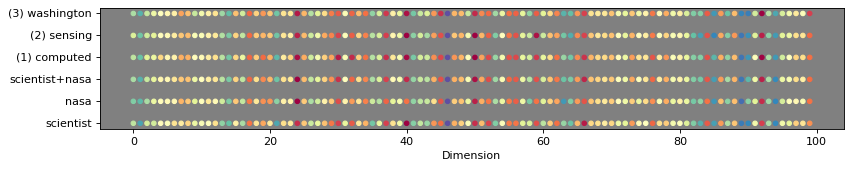

In [ ]:
words = ['water', 'planet']
compare_words_with_color(words, "minus", model_small)

words = ['ice', 'himalayas']
compare_words_with_color(words, "minus", model_small)

words = ['asia', 'india']
compare_words_with_color(words, "plus", model_small)

words = ['cold', 'hot']
compare_words_with_color(words, "plus", model_small)

words = ['scientist', 'nasa']
compare_words_with_color(words, "plus", model_small)


### Arithmetic Relationships for Model_Large

Top 3 Similar Words with Confidences
--------------------------------------------------
water 0.7362062931060791
kpa 0.49613338708877563
glucos 0.44634509086608887


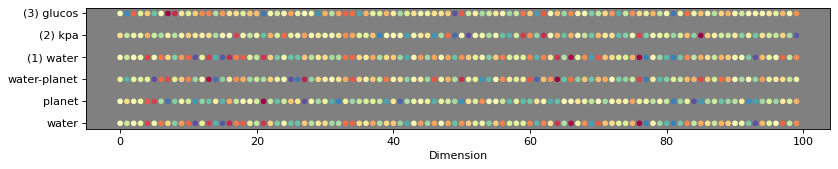

Top 3 Similar Words with Confidences
--------------------------------------------------
ice 0.9241865873336792
albedo 0.4987024664878845
thick 0.43583428859710693


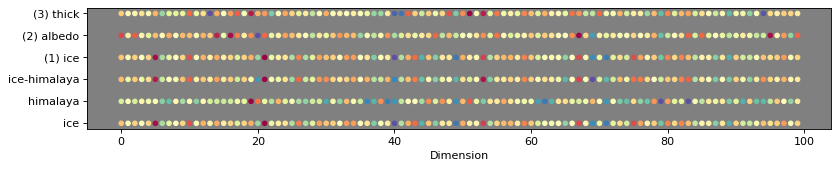

Top 3 Similar Words with Confidences
--------------------------------------------------
india 0.8607587218284607
asia 0.8409249186515808
southeast 0.6586730480194092


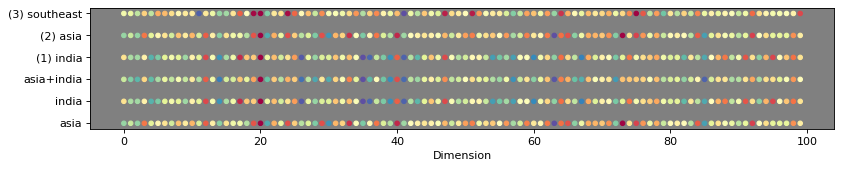

Top 3 Similar Words with Confidences
--------------------------------------------------
cold 0.9066386222839355
hot 0.8160399794578552
mild 0.6440118551254272


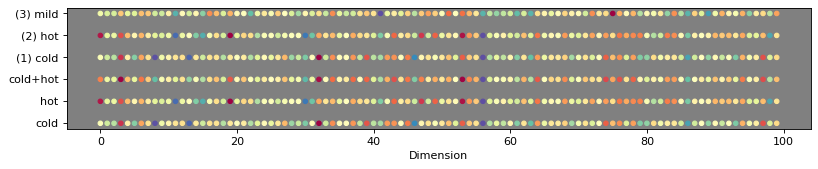

Top 3 Similar Words with Confidences
--------------------------------------------------
scientist 0.9162329435348511
nasa 0.5764948725700378
survey 0.5093568563461304


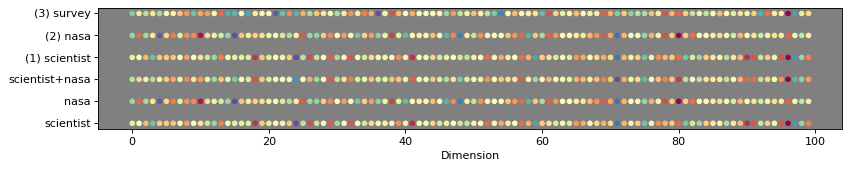

In [ ]:
words = ['water', 'planet']
compare_words_with_color(words, "minus", model_large)

words = ['ice', 'himalaya']
compare_words_with_color(words, "minus",model_large)

words = ['asia', 'india']
compare_words_with_color(words, "plus", model_large)

words = ['cold', 'hot']
compare_words_with_color(words, "plus", model_large)

words = ['scientist', 'nasa']
compare_words_with_color(words, "plus", model_large)

### Arithmetic Relationship Analysis

The results from the experiments above are compiled below, where the confidences are rounded to the nearest hundredth. Not all results make sense when viewing them alone in their present form as we are missing the underlying context behind which they were used in the document corpus, but some results do show meaningful relationships which we will discuss. 

#### Analysis of Model_Small
<!-- Math(r'\displaystyle) -->

<!-- \begin{array}{|c|c|c|c|c|c|c|}\hline\\ \\
  Model\_Small\mathcal{} & \mathcal{Word_1} & \mathcal{Word_2} & \mathcal{Arithmetic} & \mathcal{Result_1} & \mathcal{Result_2} & \mathcal{Result_3}\\ \hline\\ \\ 
  1 & water & planet    & - & trace = 0.84    & impacted = 0.83   & flows = 0.82      \\ \hline\\ \\
  2 & ice   & himalayas & - & ice = 0.99      & insulating = 0.96 & greenland = 0.96  \\ \hline\\ \\
  3 & asia  & india     & + & rainfall = 1.0  & light = 1.0       & indonesia = 1.0    \\ \hline\\ \\
  4 & cold  & hot       & + & spring = 0.99   & meanders = 0.98   & europe = 0.98      \\ \hline\\ \\
  5 & nasa  & scientist & + & computed = 0.99 & sensing = 0.99    & washington = 0.99   \\ \hline
  \end{array} -->

|Model_Small|Word_1 |Word_2|Arithmetic|Result_1|Result_2|Result_3|
| :-: |:-: |:-: |:-: |:-: |:-: |:-: |
| 1 |water|planet   |-|trace = 0.84     |impacted = 0.83   |flows = 0.82      |
| 2 |ice  |himalayas|-|ice = 0.99       |insulating = 0.96 |greenland = 0.96  |
| 3 |asia |india    |+|rainfall = 1.0   |light = 1.0       |indonesia = 1.0   |
| 4 |cold |hot      |+|spring = 0.99    |meanders = 0.98   |europe = 0.98     |
| 5 |nasa |scientist|+|computed = 0.99  |sensing = 0.99    |washington = 0.99 |
<!-- **Note: the LaTex code we used to generate the table was not compatible with the PDF Splitter on Google Colab. Please refer to the .PNG titled "Table 1 - Model_Small", which is attached to our submission, when reading this section.** -->

Model_Small has found some very interesting arithmetic relationships with a high degree of accuracy! For the first experiment, the model recognized the fact that a planet without water is impacted, which shows that the model regards water as a very important element of a planet in terms of climate change. For the second experiment, the model related the removal of ice from the Himalayas to the word melting, which is commonly how ice is removed. It also related this arithmetic relationship to insulation, which is prevalent in thermodynamics, heat transfer, and climate change in a way. For the third experiment, the model related Asia and India with rainfall and light - Asia is typically quite warm with plenty of sunshine, and heavy rains in certain regions. It also oddly related this combination to Indonesia, which seems like it just combined **India** with **Asia** to form **Indonesia** (which is located also in Southeast Asia). For the fourth experiment, it related cold and hot to spring (which is between two seasons - winter which is cold, and summer which is hot) and Europe (which is vast and has both cold and hot regions). Lastly, the model related NASA and Scientist to computed (you can't be much of a scientist without performing any computations, especially a NASA one!), sensing (NASA scientists have great awareness and probably use plenty of sensor measurement tools to record data), and most interestingly, Washington (NASA HQ is located in Washington)!

#### Analysis of Model_Large

<!-- Math(r'\displaystyle  -->
  \begin{array}{|c|c|c|c|c|c|c|}\hline\\ \\
  Model\_Large\mathcal{} & \mathcal{Word_1} & \mathcal{Word_2} & \mathcal{Arithmetic} & \mathcal{Result_1} & \mathcal{Result_2} & \mathcal{Result_3}\\ \hline\\ \\
  1 & water & planet & - & water = 0.73 & kpa = 0.50 & glucos = 0.45 \\ \hline\\ \\
  2 & ice & himalayas & - & ice = 0.92 & albedo = 0.50 & thick = 0.44  \\ \hline\\ \\
  3 & asia & india & + & india = 0.86 & asia = 0.84 & southeast = 0.66    \\ \hline\\ \\
  4 & cold & hot & + & cold = 0.91  & hot = 0.82 & mild = 0.64 \\ \hline\\ \\
  5 & nasa & scientist & + & scientist = 0.92 & nasa = 0.58 & survey = 0.51 \\ \hline
  \end{array}

In comparison to Model_Small, Model_Large produces results which are not as similar to other word embeddings, except for results which include either of the input words. For the first experiment, it interestingly related water and planet to kPa, which stands for Kilopascals - a unit of pressure measurement. This article* from the Department of Astronomy in the University of Wisconson-Madison discusses the conditions for life to form on a planet, and states: "The ambient temperature and pressure on the surface of a planet determine whether water can remain in liquid form there". The second experiment related ice and Himalayas to the scientific term Albedo, which is "a measure of how much light that hits a surface is reflected without being absorbed. Something that appears white reflects most of the light that hits it and has a high albedo, while something that looks dark absorbs most of the light that hits it, indicating a low albedo" \*\*. This shows that the model recognized the fact that the Albedo would be affected if ice was removed from the Himalayas, which is a pretty neat relationship to recognize. The third experiment does not have any interesting results. The fourth experiment picked up that cold mixed with hot equates to something mild (ie. cool, warm, pleasant). The last experiment related scientist and NASA to survey, which is interesting as NASA scientists definitely conduct many surveys.



**\*** http://www.astro.wisc.edu/~townsend/static.php?ref=diploma-3
**\*\*** https://climate.ncsu.edu/edu/Albedo#:~:text=Albedo%20(al%2Dbee%2Ddoh,it%2C%20indicating%20a%20low%20albedo. 

#### Arithmetic Model Comparison

Evaluating the results from both datasets, the following conclusions are drawn about the performance/nature of both models:
* Arithmetic performed on Model_Small outputs results which are very similar to other word embeddings, whereas arithmetic performed on Model_Large outputs results which aren't as similar to other word embeddings, **except** embeddings which include either of the input words
* Arithmetic performed on Model_Small produces different words as the top 3 results for most experiments, whereas arithmetic performed on Model_Large produces at least one of the input words as part od the top 3 results for all experiments
* Both Model_Small and Model_Large produced some interesting arithmetic relationships, as mentioned in the discussions above
* Both models produced the most meaningful results for subtraction operations when the terms were flipped. For example, we would interpret removing ice from Himalayas as "Himalayas - Ice", but this actually performed much worse for the models. Using "Ice - Himalayas" worked much better, and produced meaningful relationships
* Both models were trained on datasets which are small in general when compared to other more impressive datasets. As such, the arithmetic computations achieved here were not always the best

## Part 4

### Using Pre-trained Model to Analyze Arithmetic Relationships

In this section we load 2 pretrained models, 1 Word2Vec and 1 GloVe, to analyze the quality of these embeddings on the arithmetic relationships we had used prior. The Word2Vec model will utilize the Google News 300 dataset. The model "contains 300-dimensional vectors for 3 million words and phrases, trained on part of Google News dataset (about 100 billion words)"\*. The GloVe model will utilize a combination of two datasets: one from Wikipedia (2014), and another from Gigaword which "is a comprehensive archive of newswire text data that has been acquired over several years by the Linguistic Data Consortiume (LDC)"\*\*.

**\*** https://code.google.com/archive/p/word2vec/ 

**\*\*** https://catalog.ldc.upenn.edu/LDC2011T07 

In [ ]:
# load pretrained Word2Vec model
word2vec_model = api.load("word2vec-google-news-300")

# load pretrained GloVe model
glove_model = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 1662.8/1662.8MB downloaded
[==================================================] 100.0% 66.0/66.0MB downloaded


### Pretrained Word2Vec Model

Top 3 Similar Words with Confidences
--------------------------------------------------
water 0.5485330820083618
Water_Supply 0.42854994535446167
Water 0.4221305251121521


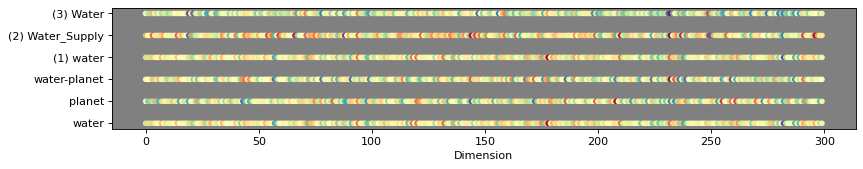

Top 3 Similar Words with Confidences
--------------------------------------------------
ice 0.5629615783691406
Ice 0.4116077423095703
coach_Clem_Jodoin 0.36888012290000916


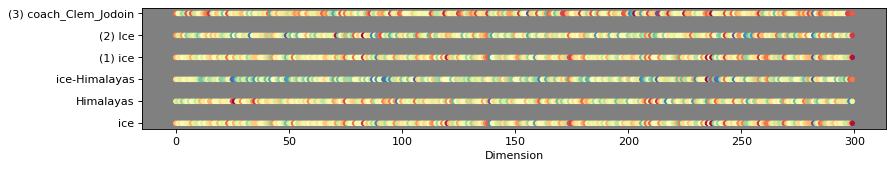

Top 3 Similar Words with Confidences
--------------------------------------------------
asia 0.8824494481086731
india 0.865939736366272
america 0.7062329053878784


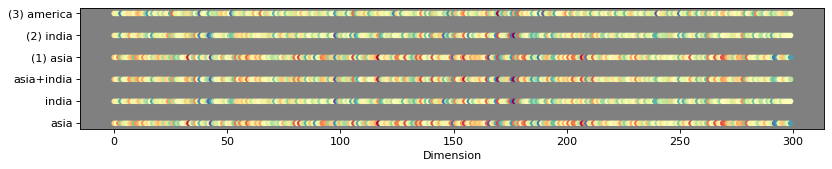

Top 3 Similar Words with Confidences
--------------------------------------------------
cold 0.8556073904037476
hot 0.8533142805099487
chilly 0.6447672843933105


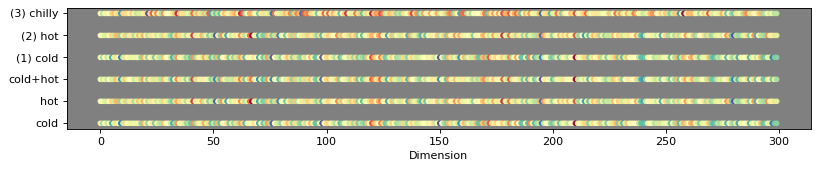

Top 3 Similar Words with Confidences
--------------------------------------------------
scientist 0.7695239186286926
nasa 0.7435135245323181
researcher 0.5963834524154663


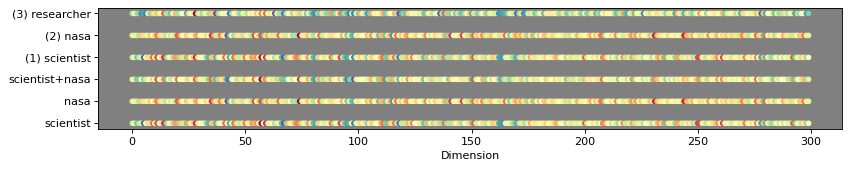

In [ ]:
words = ['water', 'planet']
compare_words_with_color(words, "minus", word2vec_model)

words = ['ice', 'Himalayas']
compare_words_with_color(words, "minus", word2vec_model)

words = ['asia', 'india']
compare_words_with_color(words, "plus", word2vec_model)

words = ['cold', 'hot']
compare_words_with_color(words, "plus", word2vec_model)

words = ['scientist', 'nasa']
compare_words_with_color(words, "plus", word2vec_model)

### Pretrained GloVe Model

Top 3 Similar Words with Confidences
--------------------------------------------------
water 0.6569976806640625
drinking 0.6502435207366943
sewage 0.6120321154594421


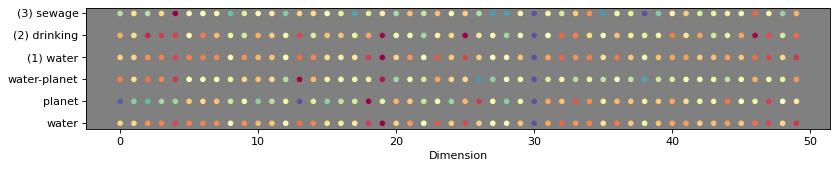

Top 3 Similar Words with Confidences
--------------------------------------------------
leafs 0.6701161861419678
canadiens 0.6359095573425293
sox 0.6132856011390686


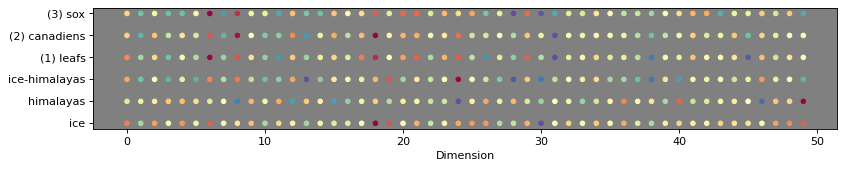

Top 3 Similar Words with Confidences
--------------------------------------------------
india 0.9189521670341492
asia 0.9142413139343262
malaysia 0.8413666486740112


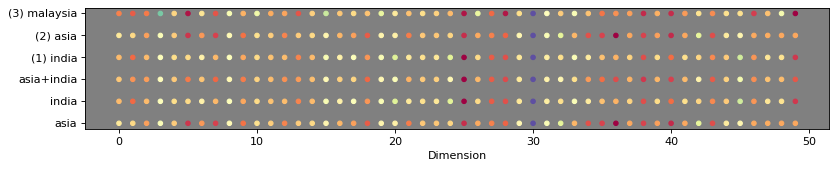

Top 3 Similar Words with Confidences
--------------------------------------------------
cold 0.9491984248161316
hot 0.9487224221229553
cool 0.8803012371063232


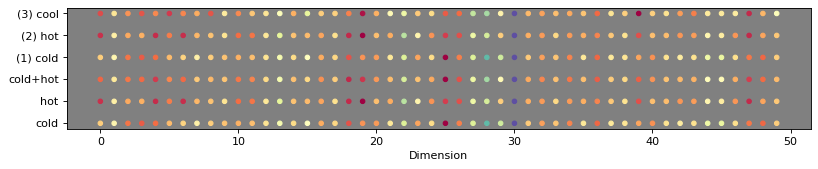

Top 3 Similar Words with Confidences
--------------------------------------------------
nasa 0.8741116523742676
scientist 0.867865800857544
laboratory 0.7631377577781677


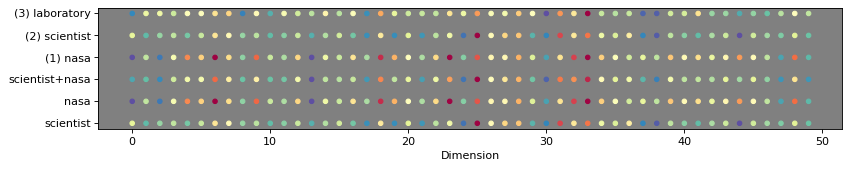

In [ ]:
words = ['water', 'planet']
compare_words_with_color(words, "minus", glove_model)

words = ['ice', 'himalayas']
compare_words_with_color(words, "minus", glove_model)

words = ['asia', 'india']
compare_words_with_color(words, "plus",  glove_model)

words = ['cold', 'hot']
compare_words_with_color(words, "plus",  glove_model)

words = ['scientist', 'nasa']
compare_words_with_color(words, "plus",  glove_model)

### Arithmetic Relationship Analysis

The results from the experiments above are compiled below, where the confidences are rounded to the nearest hundredth. Not all results make sense when viewing them alone in their present form as we are missing the underlying context behind which they were used in the document corpus, but some results do show meaningful relationships which we will discuss. 



#### Analysis of Google News 300 Word2Vec
<!-- **Note: the LaTex code we used to generate the table was not compatible with the PDF Splitter on Google Colab. Please refer to the .PNG titled "Table 3 - Google Pretrained", which is attached to our submission, when reading this section.** -->

<!-- Math(r'\displaystyle \\ --> 
  \begin{array}{|c|c|c|c|c|c|c|}\hline\\ \\
  Google\_Pretrained\_Model \mathcal{} & \mathcal{Word_1} & \mathcal{Word_2} & \mathcal{Arithmetic} & \mathcal{Result_1} & \mathcal{Result_2} & \mathcal{Result_3}\\ \hline\\ \\
  1 & water & planet & - & water = 0.55 & Water\_Supply = 0.43 & Water = 0.42 \\ \hline\\ \\
  2 & ice & Himalayas & - & ice = 0.56  & Ice = 0.42 & coach\_Clem\_Jodoin = 0.39  \\ \hline\\ \\
  3 & asia & india & + & asia = 0.88 & india = 0.87 & america = 0.70    \\ \hline\\ \\
  4 & cold & hot & + & cold = 0.86  & hot = 0.85 & chilly = 0.64 \\ \hline\\ \\
  5 & nasa & scientist & + & scientist = 0.77 & nasa = 0.74 & researcher = 0.60 \\ \hline
  \end{array}
  

The Google News model seems to group the results of the arithmetic with the individual words themselves, and the results of each experiment seems to be related to a specific topic. For the first experiment, the arithmetic of water and planet yields the terms water, Water_Supply, and Water - note the use of capitals and underscores here! The Google News model does not remove capitalization and underscores when preprocessing, probably because Google had deemed those textual attributes important in the context of news data. This defers from our approach, where we made all text lowercase and removed all punctuation. Although "Water_Supply" looks odd in a sentence, this may refer to a variable within a formula or table. Initially, we tried using the word "himalayas" within this model, but the model insisted that the word was not present within its embedding. Upon running experiment 1 and realizing that capitalization matters for this model, we included "Himalayas", which worked. For the second experiment, the model related the arithmetic of ice and Himalayas to two versions of ice - one capitalized and the other all lowercase. This shows that this model counts every variation of a word as a unique instance, and keeps all instances (ex. ice, ICE, Ice would all be kept). In light of this, it is strange that "Himalayas" works but "himalayas" doesn't - perhaps the lowercase version of it exists in a larger corpus of the Google News dataset. It interestingly related ice and Himalayas to one "Clem Jodoin" - upon Googling him, this gentlemans' full name is "Clément Jodoin", and he is a retired ice hockey player and former head coach in the American Hockey League. There is no mention relating him to the Himalayas on Google, so it is strange that the model outputted his name as the third highest result. The model might be placing anything related to ice and snow in the same grouping.  For the third experiment, the arithmetic of india and asia resulted in america. When capitalizing India and Asia, the third result was "Southeast_Asia" (not show in Figures above for the sake of brevity) - this shows that the model groups geographic regions together. For the fourth experiment, cold and hot resulted in chilly. For the fifth experiment, scientist and nasa resulted in researcher, which makes sense. Capitalizing nasa here to NASA resulted in the lowercase form, nasa, as its third result (not show in Figures above for the sake of brevity).



#### Analysis of Wiki Gigaword 50 GloVe Model
<!-- **Note: the LaTex code we used to generate the table was not compatible with the PDF Splitter on Google Colab. Please refer to the .PNG titled "Table 4 - Wiki Pretrained", which is attached to our submission, when reading this section.** -->
<!-- Math(r'\displaystyle \\ -->
  \begin{array}{|c|c|c|c|c|c|c|}\hline\\ \\
  Wiki\_Pretrained\_Model\mathcal{} & \mathcal{Word_1} & \mathcal{Word_2} & \mathcal{Arithmetic} & \mathcal{Result_1} & \mathcal{Result_2} & \mathcal{Result_3}\\ \hline\\ \\
  1 & water & planet & - & water = 0.66 & drinking = 0.65 & sewage = 0.61 \\ \hline\\ \\
  2 & ice & himalayas & - & leafs  = 0.67 & canadiens = 0.64 & sox = 0.61  \\ \hline\\ \\
  3 & asia & india & + & india = 0.92 & asia = 0.91 & malaysia  = 0.84    \\ \hline\\ \\
  4 & cold & hot & + & cold = 0.95  & hot = 0.95 & cool = 0.88 \\ \hline\\ \\
  5 & nasa & scientist & + & nasa = 0.87 & scientist = 0.87 & laboratory = 0.76 \\ \hline
  \end{array}

In comparison, the GloVe model does not seem to use capitalization or punctuation like the Google News model. For the first experiment, the model related water and planet to drinking and sewage. Water is arguably the most important element within a planet for humans, as it helps us with many tasks such as sewage treatment and provides us the means to our very existence (ie. hydration) - the results seem fitting that without water, a planet is not very useful to us. For the second experiment, the model related ice and himalayas to leafs, canadiens and sox - these are all sports teams. The leafs refer to the Toronto Maple Leafs (hockey), canadiens refer to the Montreal Canadiens (hockey), and sox refers to the Chicago White Sox (baseball). This is a bit odd as these teams do not have any relationship with the Himalayas, and only the first two results have a relationship with ice. It seems like the model may much more mentions of ice than himalayas, which is why the results of the arithmetic latch onto embeddings that have connections with ice - this is just our hypothesis. For the third experiment, the model seems to group geographic regions together like the Google model. For the fourth experiment, again the model seems to group temperatures together. For the fifth experiment, the model identified laboratory as a relevant word to the arithmetic of nasa and scientist, which makes sense. In conclusion, almost all results make sense.

#### Google Word2Vec vs Wiki GloVe vs Climate Change Model Comparisons

Evaluating the results from all models, the following conclusions are drawn:
* GloVe seems to produce results which are more likely to show up in a regular situation than Word2Vec. GloVe, in general, produced results which all seemed to relate to the input words whereas Word2Vec sometimes produced some rare results like "Coach_Clem_Jodoin". This is why GloVe is advantageous, since it uses a global occurrence of the word along with a local relationship, thereby creating a balance between normal and rare occurences 
* GloVe in general, produced outputs with a higher confidence measure than the pretrained Word2Vec models did
* Both pretrained models, for the most part, produced words from the arithmetic computations that made sense, whereas our climate Change models produced more results which didn't make sense. The ability of the pretained Word2Vec model can be attributed to its large amount of data from a varied document corpus, and the ability of the pretrained GloVe model can be attributed to its "aggregated global word-word co-occurrence statistics"*
* Although the size of the pretrained models are much bigger than our Climate Change model, we can see that the pretrained Word2Vec model still doesn't have a high confidence measure for results which are not part of the input words

**\*** Excerpt from Professor Crowley's Week 7 Lecture Slides  